# Линейная регрессия

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [2]:
df = pd.read_csv('data/lin_reg.txt', header=None)
mapper = {
    0: 'x1',
    1: 'x2',
    2: 'x3',
    3: 'x4',
    4: 'y',
}
df.rename(columns=mapper, inplace=True)

X = df[['x1', 'x2', 'x3', 'x4']].values
Y = df[['y']].values

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
def forward_pass(w, X):
    b = w[0] * np.ones((X.shape[0], 1))
    w = w[1:]
    assert w.shape[0] == X.shape[1]
    assert b.shape[0] == X.shape[0]
    return  (X @ w).reshape(-1, 1) + b.reshape(-1, 1)

In [4]:
def J(w, X, Y, a=0):
    return np.sum(np.power(forward_pass(w, X) - Y, 2)) / len(Y) + a * (np.sum(np.power(w, 2)))

In [5]:
def train_test_split(X, train_size=0.8):
    n = X.shape[0]
    pivot = int(n * train_size)
    return X[:pivot], X[pivot:]

In [6]:
def train_test_split_df(df):
    train, test = train_test_split(df)
    X_train = train[['x1', 'x2', 'x3', 'x4']].values
    X_test = test[['x1', 'x2', 'x3', 'x4']].values
    Y_train = train[['y']].values
    Y_test = test[['y']].values
    return X_train, X_test, Y_train, Y_test

In [7]:
def fit_linear(X, Y, a=0, plot=False):
    history = {
        'w': [],
        'error': [],
    }
    
    def callback(w):
        history['w'].append(w)
        history['error'].append(J(w, X, Y))
    optimal_w = minimize(J, x0=np.zeros((X.shape[1] + 1, 1)), args=(X, Y, a), callback=callback, method='BFGS').x
    
    if plot:
        plot_learning_curve(history)
    return optimal_w, history

# 1. Зависимость среднеквадратичной ошибки от $a$

Перебираем значение параметра в промежутке $a \in[0, 1]$

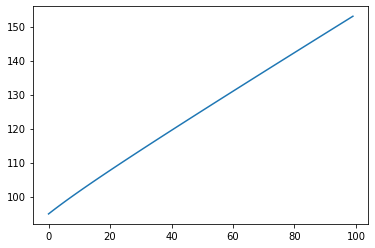

In [8]:
errors = []
for a in np.linspace(0, 1, 100):
    w_optimal, _ = fit_linear(X, Y, a=a)
    error = J(w_optimal, X, Y, a=a)
    errors.append(error)
    
plt.plot(errors)

# 2 Кросс-валидация

In [9]:
def cross_validation(df, cv=5, a=0):
    shuffled_df = df.sample(frac=1)
    n = len(shuffled_df)
    pivot_step = n // cv
    
    history = {
        'train_error': [],
        'test_error': []
    }
    for pivot in range(0, n, pivot_step):
        fold = shuffled_df[pivot:pivot + pivot_step]
        X_train, X_test, Y_train, Y_test = train_test_split_df(fold)
        w_optimal, _ = fit_linear(X_train, Y_train, a=a)
        history['train_error'].append(J(w_optimal, X_train, Y_train))
        history['test_error'].append(J(w_optimal, X_test, Y_test))
    return history

In [10]:
def mean_cv_history(history):
    return np.array(history['test_error']).mean()

# 3 Оптимальное $a$

In [11]:
mean_errors = {}
for a in np.linspace(0, 1, 30):
    history_cv = cross_validation(df, a=a)  
    mean_errors[a] = mean_cv_history(history_cv)
min_val = sorted(mean_errors.items(), key=lambda x: x[1])[0]
optimal_a = min_val[0]
print(f'Оптимальное a={min_val[0]}, MSE при этом {min_val[1]}')

Оптимальное a=0.06896551724137931, MSE при этом 87.77506949099809


# 4, 5 Валидационная кривая и кривая обучения

Кривые близки, переобучения нет

In [12]:
def plot_learning_curve(history, X_test, Y_test, optimal_a):
    val_score = []
    for w in history['w']:
        val_score.append(J(w, X_test, Y_test, a=optimal_a))
    
    plt.figure()
    
    plt.plot(history['error'])
    plt.plot(val_score)
    
    plt.legend(['train', 'test'])
    plt.title('Learning curve')

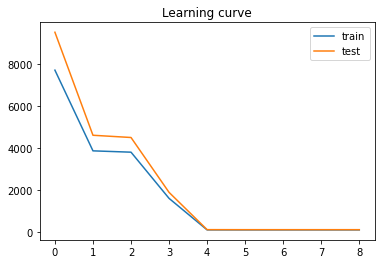

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split_df(df)
w, history = fit_linear(X_train, Y_train, a=optimal_a)
plot_learning_curve(history, X_test, Y_test, optimal_a)